In [1]:
import scipy
import scipy.fftpack
import scipy.special
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import time
from pathlib import Path
import pickle
import timeit
import sys, os
import pandas as pd

import pycoss.rod as rod
import pycoss.rod.interp.FFT as FFT
from pycoss.rod.helpers import *
from pycoss.rod.integrators import *
import pycoss.rod.helpers.plotting as plotting

In [2]:
np.seterr(all='raise')
import warnings
warnings.filterwarnings(action="error", category=np.ComplexWarning)

In [3]:
def run_sim(run_name, dt, integrator):
    # ## Parameters

    # +
    L0 = 1
    L = 2
    dim = 3

    Nm = 200
    Mm = 1024
    Mm_render = Nm*100
    Mm_save = Nm*10

    # Generate curve

    random_seed = 3323
    frame_rot_ampl = 3
    N_random_curve_modes = 3
    mu_random_curve = 0
    sigma_random_curve = 0.3

    # System parameters

    lmbd = 1

    # Simulation parameters

    T = 20
    taylor_tol = 1e-2

    # Misc

    N_save = 100
    N_clock = 100
    N_integrator_trials = int(1e4)
    # -



    # ## Initial conditions

    # +
    fft_Nm = Nm//2 + 1

    us = FFT.grid(Mm, L0)
    us_ext = np.linspace(0, L0, Mm+1, endpoint=True)
    du = us[1] - us[0]

    us_save = FFT.grid(Mm, L0)
    us_save_ext = np.linspace(0, L0, Mm_save+1, endpoint=True)
    du_save = us[1] - us[0]
    # -

    path_handler = FFT.FourierHandler(dim, Nm, Mm, L0)
    path_handler_render = FFT.FourierHandler(dim, Nm, Mm_render, L0)

    frame_rot_th = np.sin(2*np.pi*path_handler_render.grid/L0) * frame_rot_ampl
    frame_rot_phi = np.cos(2*np.pi*path_handler_render.grid/L0) * frame_rot_ampl
    frame_rot_psi = np.sin(2*np.pi*path_handler_render.grid/L0) * frame_rot_ampl

    if random_seed != -1:
        np.random.seed(random_seed)

    # +
    cn_K = np.random.random((3,3))

    cn_K = cn_K + cn_K.T
    cn_K += np.eye(3) * 3
    cn_K /= np.max(np.linalg.eigvals(cn_K))

    cn_K *= 1e-2


    cn_Eps = np.random.random((3,3))

    cn_Eps = cn_Eps + cn_Eps.T
    cn_Eps += np.eye(3) * 3
    cn_Eps /= np.max(np.linalg.eigvals(cn_Eps))

    cn_Eps *= 1e-3


    # +
    def generate_random_periodic_function(dim, us, L, N, mu, sigma):
        fs = np.zeros((3, len(us)))
        dfs = np.zeros((3, len(us)))

        for i in range(dim):
            fs[i] += np.random.normal(mu, sigma)/2

            for j in range(1, N):
                a, b= np.random.normal(mu, sigma), np.random.normal(mu, sigma)

                fs[i] += a * np.cos((2*np.pi/L)*j*us) / (j*np.pi)
                fs[i] += b * np.sin((2*np.pi/L)*j*us) / (j*np.pi)

                dfs[i] += -(a * (2*np.pi/L)*j / (j*np.pi)) * np.sin((2*np.pi/L)*j*us)
                dfs[i] += (b * (2*np.pi/L)*j / (j*np.pi)) * np.cos((2*np.pi/L)*j*us)

        return fs, dfs

    R0_raw, dR0_raw = generate_random_periodic_function(dim, path_handler_render.grid, L0,
                                           N_random_curve_modes, mu_random_curve, sigma_random_curve)

    #fig = plt.figure(figsize=(10,10))
    #plot_centerline(R0_raw, fig=fig)
    ##plt.show()

    # +
    c_th0, c_pi0, R_u0, E_u0, R_err0, close_err0 = get_differential_invariants_from_curve(R0_raw, Nm, Mm,
                                                                        L0, L=L, err_tol=1e-1, dR=dR0_raw)

    c_th0_render = path_handler.change_Mm(c_th0, Mm, Mm_render)
    c_pi0_render = path_handler.change_Mm(c_pi0, Mm, Mm_render)

    th0_render = path_handler_render.iDT(c_th0_render)
    pi0_render = path_handler_render.iDT(c_pi0_render)

    # Rotate the frame

    frame_rotation = eul2rot([frame_rot_th, frame_rot_phi, frame_rot_psi])

    du_frame_rotation = np.zeros(frame_rotation.shape)
    for i in range(3):
        du_frame_rotation[i,:] = path_handler_render.diff_f( frame_rotation[i,:] )

    pi0_hat_render = hat_vec_to_mat(pi0_render)

    transformed_pi0_hat_render = np.einsum('iju,kju->iku', du_frame_rotation, frame_rotation)
    transformed_pi0_hat_render += np.einsum('iju,jku,lku->ilu', frame_rotation, pi0_hat_render, frame_rotation)
    transformed_pi0_render = hat_mat_to_vec(transformed_pi0_hat_render)

    transformed_th0_render = np.einsum('iju,ju->iu', frame_rotation, th0_render)

    E_u0 = E_u0.dot(frame_rotation[...,0].T)

    th0_render = transformed_th0_render
    pi0_render = transformed_pi0_render

    # Transform back to Fourier modes

    c_th0_render = path_handler_render.DT(th0_render)
    c_pi0_render = path_handler_render.DT(pi0_render)

    c_th0 = path_handler.change_Mm(c_th0_render, Mm_render, Mm)
    c_pi0 = path_handler.change_Mm(c_pi0_render, Mm_render, Mm)

    c_th0_render = path_handler.change_Mm(c_th0, Mm, Mm_render)
    c_pi0_render = path_handler.change_Mm(c_pi0, Mm, Mm_render)

    th0_render = path_handler_render.iDT(c_th0_render)
    pi0_render = path_handler_render.iDT(c_pi0_render)

    th0 = path_handler.iDT(c_th0)
    pi0 = path_handler.iDT(c_pi0)

    # Plot rod

    Fr0_u0 = construct_oriented_frame(R_u0, E_u0)
    Fr0, R0, E0 = reconstruct_frame(th0_render, hat_vec_to_mat(pi0_render), L0, R_u0, E_u0)

    fig = plt.figure(figsize=(10,10))
    plotting.plot_centerline_and_frame(R0, E0, fig=fig, N_frame=10, frame_scale=0.03)
    #plt.show()
    plt.close()

    print('R_err:', R_err0)
    print('close_err:', close_err0)
    # -

    d = 1e-3
    fig, ax = plt.subplots()
    ax.plot(R0[0], R0[1])
    ax.plot([R0[0,-1],R0[0,0]], [R0[1,-1],R0[1,0]])
    ax.set_xlim(R0[0,-1]-d, R0[0,-1]+d)
    ax.set_ylim(R0[1,-1]-d, R0[1,-1]+d)
    #plt.show()
    plt.close()

    fig, ax = plt.subplots()
    ax.plot(np.abs(c_pi0[2]))
    ax.set_yscale('log')
    #plt.show()
    plt.close()

    # ## Define dynamics

    # +
    th_ground = np.zeros((3,Mm))
    th_ground[0] = 1

    def compute_F(t, th, pi, out=None):
        F = np.einsum('ij,ju->iu', cn_K, th-th_ground, out=out)
        return F

    def compute_M(t, th, pi, out=None):
        M = np.einsum('ij,ju->iu', cn_Eps, pi, out=out)
        return M

    th_ext_ground = np.zeros((3,Mm+1))
    th_ext_ground[0] = 1

    def compute_U_T(us, th, pi):
        dth = th - th_ext_ground
        U_T = np.einsum('iu,ij,ju->u', dth, cn_K, dth)
        U_T = np.trapz(U_T, us)*0.5
        return U_T

    def compute_U_R(us, th, pi):
        U_R = np.einsum('iu,ij,ju->u', pi, cn_Eps, pi)
        U_R = np.trapz(U_R, us)*0.5
        return U_R

    def compute_U(us, th, pi):
        return compute_U_T(us, th, pi) + compute_U_R(us, th, pi)


    # +
    U0 = compute_U(path_handler.grid_ext,
                          path_handler.get_ext_f(th0, c_th0),
                          path_handler.get_ext_f(pi0, c_pi0))
    U_T0 = compute_U_T(path_handler.grid_ext,
                          path_handler.get_ext_f(th0, c_th0),
                          path_handler.get_ext_f(pi0, c_pi0))
    U_R0 = compute_U_R(path_handler.grid_ext,
                          path_handler.get_ext_f(th0, c_th0),
                          path_handler.get_ext_f(pi0, c_pi0))

    print('U:', U0)
    print('U_T:', U_T0)
    print('U_R:', U_R0)
    # -

    # ## Simulate

    params = {
        'T' : T,
        'dt' : dt,
        'taylor_tol' : taylor_tol,

        'lmbd' : lmbd,

        'path_handler' : path_handler,
        'path_handler_render' : path_handler_render,

        'c_pi0' : c_pi0,
        'c_th0' : c_th0,
        'Fr0_u0' : Fr0_u0,

        'F' : compute_F,
        'M' : compute_M,

        'U_T' : compute_U_T,
        'U_R' : compute_U_R,

        'N_save' : N_save,
        'Mm_save' : Mm_save,

        'N_clock' : N_clock,

        'save_ts' : False,
    }

    params['integrator'] = globals()[integrator]
    sim_res = rod.sim.OD_simulate(params)

    # ## Saving results

    # +
    data_path = Path(output_folder, sim_name, scenario_name, run_name)
    data_path.mkdir(parents=True, exist_ok=True)

    figs_path = Path(data_path, 'figs')
    figs_path.mkdir(parents=True, exist_ok=True)
    # -

    pickle.dump(sim_res, open(Path( data_path, 'sim_res.pkl' ), 'wb'))

    # +
    _params = dict.copy(params)

    del _params['path_handler']
    del _params['path_handler_render']
    del _params['F']
    del _params['M']
    del _params['U_T']
    del _params['U_R']
    _params['integrator'] = integrator

    pickle.dump(_params, open(Path( data_path, 'params.pkl' ), 'wb'))
    # -

    # ### Stats

    # +
    c_th = sim_res['c_th']
    c_pi = sim_res['c_pi']
    t = 0
    dt = params['dt']
    lmbd = params['lmbd']
    taylor_tol = params['taylor_tol']

    func = globals()[integrator]
    lfunc = lambda: func(c_th, c_pi, t, dt, compute_F, compute_M, path_handler,
                     lmbd, taylor_tol, pre_transform=None, post_transform=None)
    integrator_time_single_step = timeit.timeit(lfunc, number=N_integrator_trials)/N_integrator_trials
    integrator_time = integrator_time_single_step * sim_res['Nt']
    integrator_time /= 60**2

    # +
    stats = {
        'integrator_time' : integrator_time,
        'integrator_time_single_step' : integrator_time_single_step,
        'sim_run_time' : sim_res['sim_run_time'],
        'sim_run_time2' : sim_res['sim_run_time2'],

        'U0' : U0,
        'U_T0' : U_T0,
        'U_R0' : U_R0,

        'Uf' : sim_res['U'][-1],
        'U_Tf' : sim_res['U_T'][-1],
        'U_Rf' : sim_res['U_R'][-1],

        'close_err_f' : sim_res['close_err_f'],
    }

    pickle.dump(stats, open(Path( data_path, 'stats.pkl' ), 'wb'))
    # -

    with open(Path( data_path, 'stats.txt' ), 'w') as f:
        for k, v in stats.items():
            f.write('%s: %s\n' % (k,v))

    # ### Figures

    plt.rcParams['figure.facecolor'] = 'white'

    # +
    fig, ax = plt.subplots()

    ts = np.linspace(0, T, len(sim_res['U']))

    ax.plot(ts, sim_res['U'], label='U')
    ax.plot(ts, sim_res['U_T'], label='U_T')
    ax.plot(ts, sim_res['U_R'], label='U_R')
    ax.set_yscale('log')

    plt.legend()

    fig.savefig(Path( figs_path, 'U.png' ))
    plt.close()
    # -

    fig, ax = plotting.plot_centerline_2D(sim_res['saved_R'][0])
    ax.set_title('R0 vs Rf')
    plotting.plot_centerline_2D(sim_res['saved_R'][-1], fig=fig, ax=ax)
    plt.tight_layout()
    #plt.show()
    fig.savefig(Path( figs_path, 'R0_vs_Rf.png' ))
    plt.close()

    fig, ax = plt.subplots()
    ax.set_title('R0 gap')
    R = R0
    d = np.linalg.norm(R[:,0] - R[:,-1])*2
    ax.plot(R[0], R[1])
    ax.plot([R[0,-1],R[0,0]], [R[1,-1],R[1,0]])
    ax.set_xlim(R[0,-1]-d, R[0,-1]+d)
    ax.set_ylim(R[1,-1]-d, R[1,-1]+d)
    fig.savefig(Path( figs_path, 'R0_gap.png' ))
    #plt.show()
    plt.close()

    fig, ax = plt.subplots()
    ax.set_title('Rf gap')
    R = sim_res['Rf']
    d = np.linalg.norm(R[:,0] - R[:,-1])*2
    ax.plot(R[0], R[1])
    ax.plot([R[0,-1],R[0,0]], [R[1,-1],R[1,0]])
    ax.set_xlim(R[0,-1]-d, R[0,-1]+d)
    ax.set_ylim(R[1,-1]-d, R[1,-1]+d)
    fig.savefig(Path( figs_path, 'Rf_gap.png' ))
    #plt.show()
    plt.close()

    fig, ax = plt.subplots()
    ax.set_title('pi0 mode dist')
    ax.plot(np.abs(c_pi0[0]), label='0')
    ax.plot(np.abs(c_pi0[1]), label='1')
    ax.plot(np.abs(c_pi0[2]), label='2')
    ax.set_yscale('log')
    ax.legend()
    fig.savefig(Path( figs_path, 'pi0_mode_dist.png' ))
    #plt.show()
    plt.close()

    fig, ax = plt.subplots()
    ax.set_title('pi_f mode dist')
    ax.plot(np.abs(sim_res['c_pi'][0]), label='0')
    ax.plot(np.abs(sim_res['c_pi'][1]), label='1')
    ax.plot(np.abs(sim_res['c_pi'][2]), label='2')
    ax.set_yscale('log')
    ax.legend()
    fig.savefig(Path( figs_path, 'pi_f_mode_dist.png' ))
    #plt.show()
    plt.close()

    fig, ax = plt.subplots()
    ax.set_title('th0 mode dist')
    ax.plot(np.abs(c_th0[0]), label='0')
    ax.plot(np.abs(c_th0[1]), label='1')
    ax.plot(np.abs(c_th0[2]), label='2')
    ax.set_yscale('log')
    ax.legend()
    fig.savefig(Path( figs_path, 'th0_mode_dist.png' ))
    #plt.show()
    plt.close()

    fig, ax = plt.subplots()
    ax.set_title('th_f mode dist')
    ax.plot(np.abs(sim_res['c_th'][0]), label='0')
    ax.plot(np.abs(sim_res['c_th'][1]), label='1')
    ax.plot(np.abs(sim_res['c_th'][2]), label='2')
    ax.set_yscale('log')
    ax.legend()
    fig.savefig(Path( figs_path, 'th_f_mode_dist.png' ))
    #plt.show()
    plt.close()

    # +
    R = sim_res['saved_R'][0]
    d = max(R[0]) - np.min(R[0])
    d = max(d, np.max(R[1]) - np.min(R[1]))
    d = max(d, np.max(R[2]) - np.min(R[2]))
    frame_scale = d/20
    N_frame = 15

    plotting.vid_centerline_and_frame_3D(sim_res['saved_R'], sim_res['saved_E'],
                                save_name='%s/video.mp4' % data_path, frame_scale=frame_scale, N_frame=N_frame)
    #plt.show()
    plt.close()


    return params, sim_res, stats

In [4]:
sim_name = 'OD_rod_closed'
scenario_name = 'random_force1'

output_folder = '../output'

In [5]:
integrator_to_label = {
    'integrator_OD_FE' : 'FE',
    'integrator_OD_SO3' : 'SO3',
    'integrator_OD_SE3' : 'SE3'
}

In [6]:
# Params

start_order = 2
end_order = 6
reference_dt = 1e-7
dt_prefs = np.array([1, 2, 5])

ref_integrator = 'integrator_OD_SE3'

integrators = [
    'integrator_OD_FE',
    'integrator_OD_SO3',
    'integrator_OD_SE3'
]

In [7]:
# Params

start_order = 4
end_order = 6
reference_dt = 1e-7
dt_prefs = np.array([1, 2])
dt_prefs = np.array([1, 1.25, 2, 2.5, 5])

ref_integrator = 'integrator_OD_SE3'

integrators = [
    'integrator_OD_FE',
    'integrator_OD_SO3',
    'integrator_OD_SE3'
]

In [9]:
# Params

start_order = 4
end_order = 5
reference_dt = 1e-6
dt_prefs = np.array([1,2])
dt_prefs = np.array([1, 1.25, 2, 2.5, 5])

ref_integrator = 'integrator_OD_SE3'

integrators = [
    'integrator_OD_FE',
    'integrator_OD_SO3',
    'integrator_OD_SE3'
]

In [ ]:
# Params

start_order = 3
end_order = 6
reference_dt = 1e-7
dt_prefs = np.array([1, 1.25, 2, 2.5, 5])

ref_integrator = 'integrator_OD_SE3'

integrators = [
    'integrator_OD_FE',
    'integrator_OD_SO3',
    'integrator_OD_SE3'
]

In [10]:
#divisors_1000 = np.array([1, 2, 4, 5, 8, 10, 20, 25, 40, 50, 100, 125, 200, 250, 500, 1000])
#dt_prefs = np.array([1, 1.25, 2, 2.5, 5])
dts = []
for i in range(start_order, end_order+1):
    for p in dt_prefs:
        dts.append(10**(-i) * p)
dts = np.array(dts)
dts = np.sort(dts)[::-1]

In [11]:
int_single_step = 0.0005721170749999998
sim_T = 10
est_sim_time = 0

for dt in dts:
    est_sim_time += 3 * (sim_T / dt) * int_single_step

In [12]:
est_sim_time / (60*60)

1.520877891041666

In [13]:
backend_ =  mpl.get_backend() 
#mpl.use("Agg")  # Prevent showing stuff

# Run sims

#divisors_1000 = np.array([1, 2, 4, 5, 8, 10, 20, 25, 40, 50, 100, 125, 200, 250, 500, 1000])
#dt_prefs = np.array([1, 1.25, 2, 2.5, 5])
dts = []
for i in range(start_order, end_order+1):
    for p in dt_prefs:
        dts.append(10**(-i) * p)
dts = np.array(dts)
dts = np.sort(dts)[::-1]

#ref_params = {}
#ref_sim_res = {}
#ref_stats = {}

print('\n## Simulating reference.\t dt=%s\n' % "{:,.2e}".format(reference_dt))

ref_params, ref_sim_res, ref_stats = run_sim('dt=%s' % "{:,.2e}".format(reference_dt), reference_dt, ref_integrator)

dts_params = {}
dts_sim_res = {}
dts_stats = {}

for integrator in integrators:
    
    print('\n#### %s\n' % integrator)
    
    #print('\n## Simulating reference.\t dt=%s\n' % "{:,.2e}".format(reference_dt))
    #_ref_params, _ref_sim_res, _ref_stats = run_sim('dt=%s' % "{:,.2e}".format(reference_dt), reference_dt, integrator)
    #ref_params[integrator] = _ref_params
    #ref_sim_res[integrator] = _ref_sim_res
    #ref_stats[integrator] = _ref_stats
    
    dts_params[integrator] = []
    dts_sim_res[integrator] = []
    dts_stats[integrator] = []

    for i, dt in enumerate(dts):

        print('\n\n## (%s) Simulation %s/%s.\t dt=%s\n' % (integrator, i+1, len(dts), "{:,.2e}".format(dt)))

        run_name = 'dt=%s' % "{:,.2e}".format(dt)

        try:
            params, sim_res, stats = run_sim(run_name, dt, integrator)
            dts_params[integrator].append(params)
            dts_sim_res[integrator].append(sim_res)
            dts_stats[integrator].append(stats)
        except Exception as e:
            print('Simulation failed.')
            print(e)
            dts_params[integrator].append(None)
            dts_sim_res[integrator].append(None)
            dts_stats[integrator].append(None)
            
#mpl.use('module://matplotlib_inline.backend_inline')


## Simulating reference.	 dt=1.00e-06

R_err: 6.59979483517148e-05
close_err: 4.705958391907055e-08
U: 0.2794876511144261
U_T: 0.019046617852975317
U_R: 0.26044103326145074
100.0%. t=0.1. Time left: 0.0min                  
#### integrator_OD_FE



## (integrator_OD_FE) Simulation 1/10.	 dt=5.00e-04

R_err: 6.59979483517148e-05
close_err: 4.705958391907055e-08
U: 0.2794876511144261
U_T: 0.019046617852975317
U_R: 0.26044103326145074
Simulation failed.ft: 0.0min                      
overflow encountered in double_scalars


## (integrator_OD_FE) Simulation 2/10.	 dt=2.50e-04

R_err: 6.59979483517148e-05
close_err: 4.705958391907055e-08
U: 0.2794876511144261
U_T: 0.019046617852975317
U_R: 0.26044103326145074
Simulation failed.ft: 0.0min                      
overflow encountered in multiply


## (integrator_OD_FE) Simulation 3/10.	 dt=2.00e-04

R_err: 6.59979483517148e-05
close_err: 4.705958391907055e-08
U: 0.2794876511144261
U_T: 0.019046617852975317
U_R: 0.26044103326145074
Simulation 

# Save results

In [14]:
data_path = Path(output_folder, sim_name, scenario_name + '_results')
data_path.mkdir(parents=True, exist_ok=True)
Path(data_path, 'figs').mkdir(parents=True, exist_ok=True)

In [15]:
# Check if there are issues with the time grids

with open(Path(data_path, 'errors.txt'), 'w') as f:
    f.write('')

for integrator in dts_sim_res.keys():
    for dt, sim_res in zip(dts, dts_sim_res[integrator]):
        if sim_res is None:
            continue
            
        if not np.allclose(sim_res['saved_ts'], ref_sim_res['saved_ts']):
            print('%s has wrong saved_ts' % dt)
            with open(Path(data_path, 'errors.txt'), 'a') as f:
                f.write('%s has wrong saved_ts' % dt)

In [16]:
all_closed_errs = {}
all_Rf_sup_err = {}
all_Ef_sup_err = {}
all_Phif_sup_err = {}
all_saved_dts = {}

ref_Rf = ref_sim_res['Rf']
ref_Ef = ref_sim_res['Ef']

for ig in dts_sim_res:
    all_closed_errs[ig] = {}
    all_Rf_sup_err[ig] = {}
    all_Ef_sup_err[ig] = {}
    all_Phif_sup_err[ig] = {}
    
    for sim_res, dt in zip(dts_sim_res[ig], dts):
        
        if sim_res is None:
            all_closed_errs[ig][dt] = None
        else:
            all_closed_errs[ig][dt] = sim_res['saved_close_errs']
            all_saved_dts[dt] = sim_res['saved_ts']
            
            all_Rf_sup_err[ig][dt] = np.array([ np.max(np.abs(ref_Rf - sim_res['saved_R'][i,:,:])) for i in range(sim_res['saved_R'].shape[0]) ])
            all_Ef_sup_err[ig][dt] = np.array([ np.max(np.abs(ref_Ef - sim_res['saved_E'][i,:,:])) for i in range(sim_res['saved_E'].shape[0]) ])
            all_Phif_sup_err[ig][dt] = np.array([max(r1, r2) for r1,r2 in zip(all_Rf_sup_err[ig][dt], all_Ef_sup_err[ig][dt])])

## Figures

In [17]:
Rf_sup_errs__v__dt = {}
Rf_sup_errs__v__dt['dt'] = dts

ref_Rf = ref_sim_res['Rf']

for igf in dts_sim_res.keys():
    ig = integrator_to_label[igf]
    Rf_sup_errs__v__dt[ig] = []
    
    for dt, sim_res in zip(dts, dts_sim_res[igf]):
        if sim_res is None:
            Rf_sup_errs__v__dt[ig].append(np.nan)
        else:
            Rf = sim_res['Rf']
            err = np.max(np.abs(ref_Rf - Rf)) 
            Rf_sup_errs__v__dt[ig].append(err)

df = pd.DataFrame(Rf_sup_errs__v__dt)
df.to_csv(Path(data_path, 'Rf_sup_errs__v__dt.csv'))

df.head()

,dt,FE,SO3,SE3
0,0.000500,NaN,NaN,NaN
1,0.000250,NaN,NaN,NaN
2,0.000200,NaN,NaN,NaN
3,0.000125,0.000055,0.000013,0.000013
4,0.000100,0.000044,0.000011,0.000010


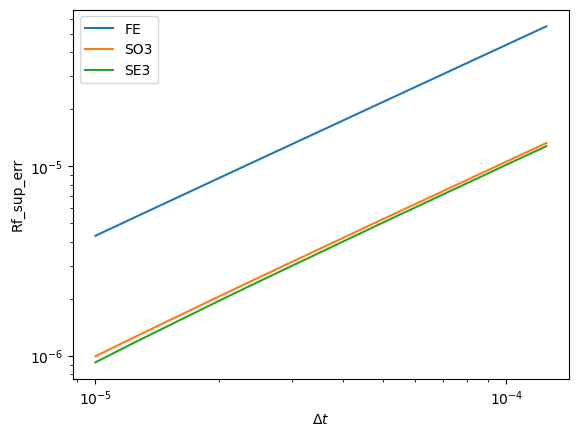

<Figure size 640x480 with 0 Axes>

In [18]:
fig, ax = plt.subplots()

ax.set_xlabel(r'$\Delta t$')
ax.set_ylabel('Rf_sup_err')

ax.set_xscale('log')
ax.set_yscale('log')

for ig in integrators:
    ax.plot(Rf_sup_errs__v__dt['dt'], Rf_sup_errs__v__dt[integrator_to_label[ig]], label=integrator_to_label[ig])
    
ax.legend()
plt.show()
fig.savefig(Path(data_path, 'figs', 'Rf_sup_errs__v__dt.pdf'),bbox_inches='tight')
plt.tight_layout()

#### `Rf_sup_errs__v__dt`

In [19]:
Rf_sup_errs__v__dt = {}
Rf_sup_errs__v__dt['dt'] = dts

ref_Rf = ref_sim_res['Rf']

for igf in dts_sim_res.keys():
    ig = integrator_to_label[igf]
    Rf_sup_errs__v__dt[ig] = []
    
    for dt, sim_res in zip(dts, dts_sim_res[igf]):
        if sim_res is None:
            Rf_sup_errs__v__dt[ig].append(np.nan)
        else:
            Rf = sim_res['Rf']
            err = np.max(np.abs(ref_Rf - Rf)) 
            Rf_sup_errs__v__dt[ig].append(err)

df = pd.DataFrame(Rf_sup_errs__v__dt)
df.to_csv(Path(data_path, 'Rf_sup_errs__v__dt.csv'))

df.head()

,dt,FE,SO3,SE3
0,0.000500,NaN,NaN,NaN
1,0.000250,NaN,NaN,NaN
2,0.000200,NaN,NaN,NaN
3,0.000125,0.000055,0.000013,0.000013
4,0.000100,0.000044,0.000011,0.000010


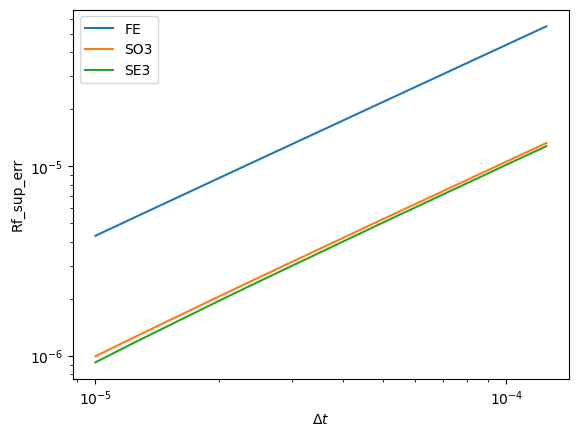

<Figure size 640x480 with 0 Axes>

In [20]:
fig, ax = plt.subplots()

ax.set_xlabel(r'$\Delta t$')
ax.set_ylabel('Rf_sup_err')

ax.set_xscale('log')
ax.set_yscale('log')

for ig in integrators:
    ax.plot(Rf_sup_errs__v__dt['dt'], Rf_sup_errs__v__dt[integrator_to_label[ig]], label=integrator_to_label[ig])
    
ax.legend()
plt.show()
fig.savefig(Path(data_path, 'figs', 'Rf_sup_errs__v__dt.pdf'),bbox_inches='tight')
plt.tight_layout()

#### `Ef_sup_errs__v__dt`

In [21]:
Ef_sup_errs__v__dt = {}
Ef_sup_errs__v__dt['dt'] = dts

ref_Ef = ref_sim_res['Ef']

for igf in dts_sim_res.keys():
    ig = integrator_to_label[igf]
    Ef_sup_errs__v__dt[ig] = []
    
    for dt, sim_res in zip(dts, dts_sim_res[igf]):
        if sim_res is None:
            Ef_sup_errs__v__dt[ig].append(np.nan)
        else:
            Ef = sim_res['Ef']
            err = np.max(np.abs(ref_Ef - Ef)) 
            Ef_sup_errs__v__dt[ig].append(err)

df = pd.DataFrame(Ef_sup_errs__v__dt)
df.to_csv(Path(data_path, 'Ef_sup_errs__v__dt.csv'))

df.head()

,dt,FE,SO3,SE3
0,0.000500,NaN,NaN,NaN
1,0.000250,NaN,NaN,NaN
2,0.000200,NaN,NaN,NaN
3,0.000125,0.000094,0.000054,0.000054
4,0.000100,0.000075,0.000043,0.000043


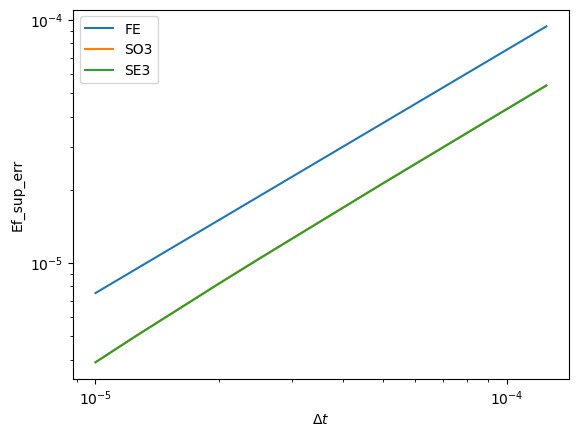

<Figure size 640x480 with 0 Axes>

In [22]:
fig, ax = plt.subplots()

ax.set_xlabel(r'$\Delta t$')
ax.set_ylabel('Ef_sup_err')

ax.set_xscale('log')
ax.set_yscale('log')

for ig in integrators:
    ax.plot(Ef_sup_errs__v__dt['dt'], Ef_sup_errs__v__dt[integrator_to_label[ig]], label=integrator_to_label[ig])
    
ax.legend()
plt.show()
fig.savefig(Path(data_path, 'figs', 'Ef_sup_errs__v__dt.pdf'),bbox_inches='tight')
plt.tight_layout()

#### Rf_sup_errs__v__sim_run_time

In [23]:
Rf_sup_errs__v__sim_run_time = {}

ref_Rf = ref_sim_res['Rf']

for igf in dts_sim_res.keys():
    ig = integrator_to_label[igf]
    
    Rf_sup_errs__v__sim_run_time[ig] = []
    Rf_sup_errs__v__sim_run_time[ig + "_sim_run_time"] = []
    
    for dt, sim_res in zip(dts, dts_sim_res[igf]):
        if sim_res is None:
            Rf_sup_errs__v__sim_run_time[ig].append(np.nan)
            Rf_sup_errs__v__sim_run_time[ig + "_sim_run_time"].append(np.nan)
        else:
            Rf = sim_res['Rf']
            err = np.max(np.abs(ref_Rf - Rf)) 
            Rf_sup_errs__v__sim_run_time[ig].append(err)
            Rf_sup_errs__v__sim_run_time[ig + "_sim_run_time"].append(sim_res['sim_run_time'])

df = pd.DataFrame(Rf_sup_errs__v__sim_run_time)
df.to_csv(Path(data_path, 'Rf_sup_errs__v__sim_run_time.csv'))

df.head()

,FE,FE_sim_run_time,SO3,SO3_sim_run_time,SE3,SE3_sim_run_time
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN
3,0.000055,0.000815,0.000013,0.000850,0.000013,0.001131
4,0.000044,0.000851,0.000011,0.000896,0.000010,0.001250


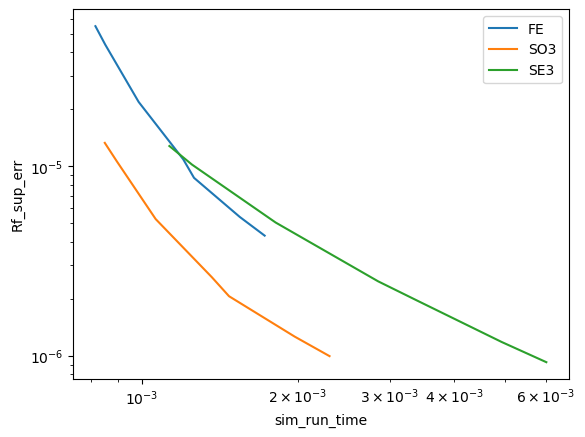

<Figure size 640x480 with 0 Axes>

In [24]:
fig, ax = plt.subplots()

for ig in integrator_to_label.values():
    sim_run_times = Rf_sup_errs__v__sim_run_time['%s_sim_run_time' % ig]
    errs = Rf_sup_errs__v__sim_run_time[ig]
    ax.plot(sim_run_times, errs, label=ig)
    
ax.set_xlabel('sim_run_time')
ax.set_ylabel('Rf_sup_err')

plt.xscale('log')
plt.yscale('log')
    
ax.legend()
plt.show()
fig.savefig(Path(data_path, 'figs', 'Rf_sup_errs__v__sim_run_time.pdf'),bbox_inches='tight')
plt.tight_layout()

#### Rf_sup_errs__v__sim_run_time2

In [25]:
Rf_sup_errs__v__sim_run_time2 = {}

ref_Rf = ref_sim_res['Rf']

for igf in dts_sim_res.keys():
    ig = integrator_to_label[igf]
    
    Rf_sup_errs__v__sim_run_time2[ig] = []
    Rf_sup_errs__v__sim_run_time2[ig + "_sim_run_time2"] = []
    
    for dt, sim_res in zip(dts, dts_sim_res[igf]):
        if sim_res is None:
            Rf_sup_errs__v__sim_run_time2[ig].append(np.nan)
            Rf_sup_errs__v__sim_run_time2[ig + "_sim_run_time2"].append(np.nan)
        else:
            Rf = sim_res['Rf']
            err = np.max(np.abs(ref_Rf - Rf)) 
            Rf_sup_errs__v__sim_run_time2[ig].append(err)
            Rf_sup_errs__v__sim_run_time2[ig + "_sim_run_time2"].append(sim_res['sim_run_time2'])

df = pd.DataFrame(Rf_sup_errs__v__sim_run_time2)
df.to_csv(Path(data_path, 'Rf_sup_errs__v__sim_run_time2.csv'))

df.head()

,FE,FE_sim_run_time2,SO3,SO3_sim_run_time2,SE3,SE3_sim_run_time2
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN
3,0.000055,0.000057,0.000013,0.000110,0.000013,0.000408
4,0.000044,0.000072,0.000011,0.000142,0.000010,0.000515


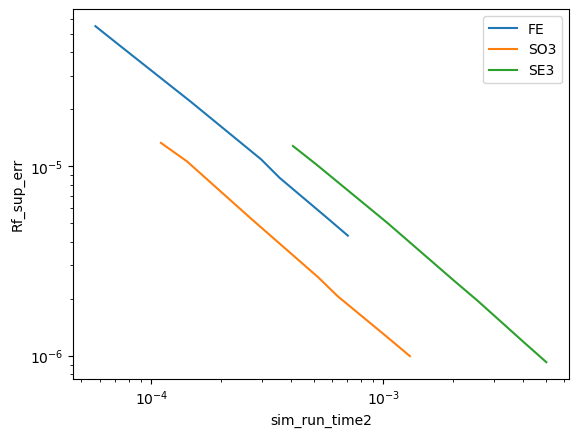

<Figure size 640x480 with 0 Axes>

In [26]:
fig, ax = plt.subplots()

for ig in integrator_to_label.values():
    sim_run_times = Rf_sup_errs__v__sim_run_time2['%s_sim_run_time2' % ig]
    errs = Rf_sup_errs__v__sim_run_time2[ig]
    ax.plot(sim_run_times, errs, label=ig)
    
ax.set_xlabel('sim_run_time2')
ax.set_ylabel('Rf_sup_err')

ax.set_xscale('log')
ax.set_yscale('log')

plt.xscale('log')
    
ax.legend()
plt.show()
fig.savefig(Path(data_path, 'figs', 'Rf_sup_errs__v__sim_run_time2.pdf'),bbox_inches='tight')
plt.tight_layout()

#### Rf_sup_errs__v__integrator_time

In [27]:
Rf_sup_errs__v__integrator_time = {}

ref_Rf = ref_sim_res['Rf']

for igf in dts_sim_res.keys():
    ig = integrator_to_label[igf]
    
    Rf_sup_errs__v__integrator_time[ig] = []
    Rf_sup_errs__v__integrator_time[ig + "_integrator_time"] = []
    
    for dt, sim_res, stats in zip(dts, dts_sim_res[igf], dts_stats[igf]):
        if sim_res is None:
            Rf_sup_errs__v__integrator_time[ig].append(np.nan)
            Rf_sup_errs__v__integrator_time[ig + "_integrator_time"].append(np.nan)
        else:
            Rf = sim_res['Rf']
            err = np.max(np.abs(ref_Rf - Rf)) 
            Rf_sup_errs__v__integrator_time[ig].append(err)
            Rf_sup_errs__v__integrator_time[ig + "_integrator_time"].append(stats['integrator_time'])

df = pd.DataFrame(Rf_sup_errs__v__integrator_time)
df.to_csv(Path(data_path, 'Rf_sup_errs__v__integrator_time.csv'))

df.head()

,FE,FE_integrator_time,SO3,SO3_integrator_time,SE3,SE3_integrator_time
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN
3,0.000055,0.000054,0.000013,0.000106,0.000013,0.000409
4,0.000044,0.000068,0.000011,0.000129,0.000010,0.000500


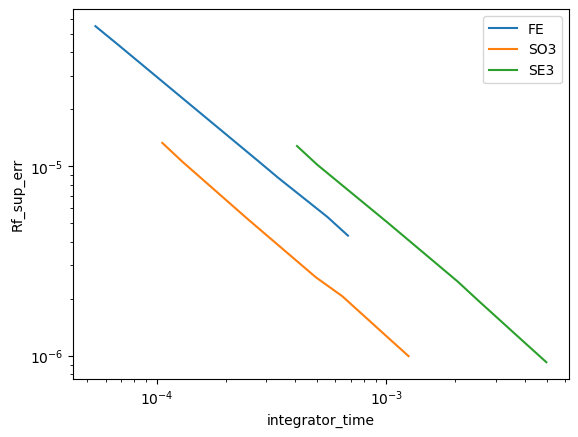

<Figure size 640x480 with 0 Axes>

In [28]:
fig, ax = plt.subplots()

for ig in integrator_to_label.values():
    sim_run_times = Rf_sup_errs__v__integrator_time['%s_integrator_time' % ig]
    errs = Rf_sup_errs__v__integrator_time[ig]
    ax.plot(sim_run_times, errs, label=ig)
    
ax.set_xlabel('integrator_time')
ax.set_ylabel('Rf_sup_err')

ax.set_xscale('log')
ax.set_yscale('log')
    
ax.legend()
plt.show()
fig.savefig(Path(data_path, 'figs', 'Rf_sup_errs__v__integrator_time.pdf'),bbox_inches='tight')
plt.tight_layout()

#### close_error__v__dt

In [29]:
dat = {}

for igf in dts_sim_res.keys():
    ig = integrator_to_label[igf]
    
    dat[ig] = []
    dat[ig + "_dt"] = []
    
    for dt, sim_res, stats in zip(dts, dts_sim_res[igf], dts_stats[igf]):
        if sim_res is None:
            dat[ig].append(np.nan)
            dat[ig + "_dt"].append(np.nan)
        else:
            dat[ig].append(sim_res['close_err_f'])
            dat[ig + "_dt"].append(dt)

df = pd.DataFrame(dat)
df.to_csv(Path(data_path, 'close_error__v__dt.csv'))

df.head()

,FE,FE_dt,SO3,SO3_dt,SE3,SE3_dt
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN
3,2.386445e-08,0.000125,1.652848e-10,0.000125,7.743214e-13,0.000125
4,1.524888e-08,0.000100,1.068658e-10,0.000100,7.743412e-13,0.000100


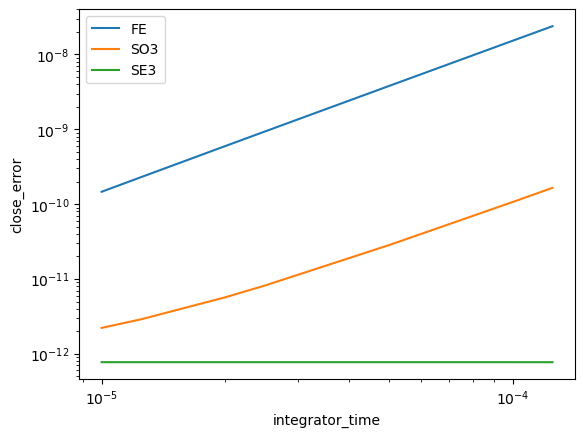

<Figure size 640x480 with 0 Axes>

In [30]:
fig, ax = plt.subplots()

for ig in integrator_to_label.values():
    ax.plot(df['%s_dt' % ig], df[ig], label=ig)
    
ax.set_xlabel('integrator_time')
ax.set_ylabel('close_error')

ax.set_xscale('log')
ax.set_yscale('log')
    
ax.legend()
plt.show()
fig.savefig(Path(data_path, 'figs', 'close_error__v__dt.pdf'),bbox_inches='tight')
plt.tight_layout()

#### close_error__v__integrator_time

In [31]:
dat = {}

for igf in dts_sim_res.keys():
    ig = integrator_to_label[igf]
    
    dat[ig] = []
    dat[ig + "_integrator_time"] = []
    
    for dt, sim_res, stats in zip(dts, dts_sim_res[igf], dts_stats[igf]):
        if sim_res is None:
            dat[ig].append(np.nan)
            dat[ig + "_integrator_time"].append(np.nan)
        else:
            dat[ig].append(sim_res['close_err_f'])
            dat[ig + "_integrator_time"].append(stats['integrator_time'])

df = pd.DataFrame(dat)
df.to_csv(Path(data_path, 'close_error__v__integrator_time.csv'))

df.head()

,FE,FE_integrator_time,SO3,SO3_integrator_time,SE3,SE3_integrator_time
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN
3,2.386445e-08,0.000054,1.652848e-10,0.000106,7.743214e-13,0.000409
4,1.524888e-08,0.000068,1.068658e-10,0.000129,7.743412e-13,0.000500


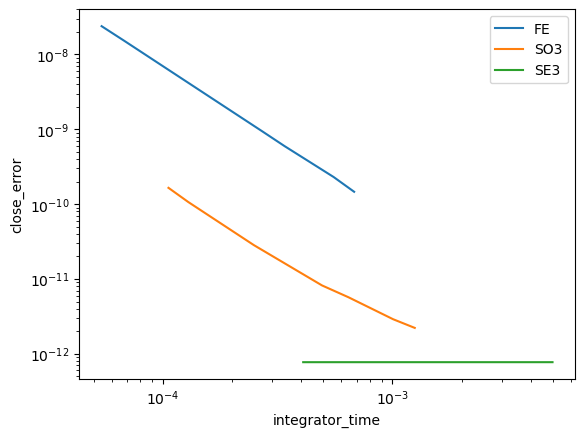

<Figure size 640x480 with 0 Axes>

In [32]:
fig, ax = plt.subplots()

for ig in integrator_to_label.values():
    ax.plot(df['%s_integrator_time' % ig], df[ig], label=ig)
    
ax.set_xlabel('integrator_time')
ax.set_ylabel('close_error')

ax.set_xscale('log')
ax.set_yscale('log')
    
ax.legend()
plt.show()
fig.savefig(Path(data_path, 'figs', 'close_error__v__integrator_time.pdf'),bbox_inches='tight')
plt.tight_layout()